In [1]:
import pandas as pd
import numpy as np
import matplotlib
import seaborn as sns

date = "241030"
box1 = "16"
box2 = "17"
cbox = box1
exp  = "WT_PTZ"

name          = date+"_"+box1+"_"+box2+"_"+exp
path          = name+"/"

# Load genotype and activity data files
genotype_file = path+date+'_'+cbox+'_genotypeMap.xlsx'
activity_file_csv = path+name+".csv"

# Columns to read from the CSV file
cols = ["location","start", "end", "animal", "stdate", "sttime", "middur"]

# Read genotype data from Excel and activity data from CSV
genotype_data = pd.read_excel(genotype_file)
activity_data = pd.read_csv(activity_file_csv, usecols=cols, low_memory=False, header=0, parse_dates=[['stdate', 'sttime']])

# Tidy the genotype data
# Melt the data so each row corresponds to a single well with Treatment info
genotype_data = genotype_data.rename(columns={'Unnamed: 0': 'Row'}).melt(id_vars='Row', var_name='Column', value_name='treatment')
genotype_data['Location'] = genotype_data['Row'] + genotype_data['Column'].astype(str)
genotype_data = genotype_data[['Location', 'treatment']]

# Adjust 'location' format in activity data from "C001" to "A1", "B1", etc.
# Strip the "C" prefix and leading zeros, then convert to "A1", "B2" format
activity_data['Location'] = activity_data['location'].str.extract('(\d+)').astype(int).apply(
    lambda x: f"{chr(65 + (x[0] - 1) // 12)}{((x[0] - 1) % 12) + 1}", axis=1)

# Merge the genotype data with activity data on Location
merged_data = activity_data.merge(genotype_data, on='Location', how='left').drop(columns=['Location'])

# Organize columns for easier reading
ordered_columns = ['location', 'animal', 'treatment'] + [col for col in merged_data.columns if col not in ['location', 'animal', 'treatment']]
final_data = merged_data[ordered_columns]

# Save the merged and tidy data to an Excel file
# output_file = '/mnt/data/corrected_merged_activity_genotype_data.xlsx'
# final_data.to_excel(output_file, index=False)

# Display the final data for inspection
# import ace_tools as tools; tools.display_dataframe_to_user(name="Corrected Merged Activity and Genotype Data", dataframe=final_data)

In [2]:

#Add clock data

# Function to calculate the 'CLOCK' column
def calculate_clock(series):
    def compute_clock(start_datetime):
        reference_time = start_datetime.replace(hour=9, minute=0, second=0)
        if start_datetime < reference_time:
            reference_time -= timedelta(days=1)
        return (start_datetime - reference_time).total_seconds() / 3600
    
    return pd.concat([pd.Series([""]), series.apply(compute_clock)])

# Calculate the 'CLOCK' column based on the combined 'stdate' and 'sttime'
final_data['clock'] = calculate_clock(final_data['stdate_sttime']).reset_index(drop=True)
final_data['clock'] = pd.to_numeric(final_data['clock'])

/var/folders/99/9p1rqw911_b36bj9w7ly35q80000gn/T/ipykernel_5237/2420153347.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data['clock'] = calculate_clock(final_data['stdate_sttime']).reset_index(drop=True)
/var/folders/99/9p1rqw911_b36bj9w7ly35q80000gn/T/ipykernel_5237/2420153347.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data['clock'] = pd.to_numeric(final_data['clock'])


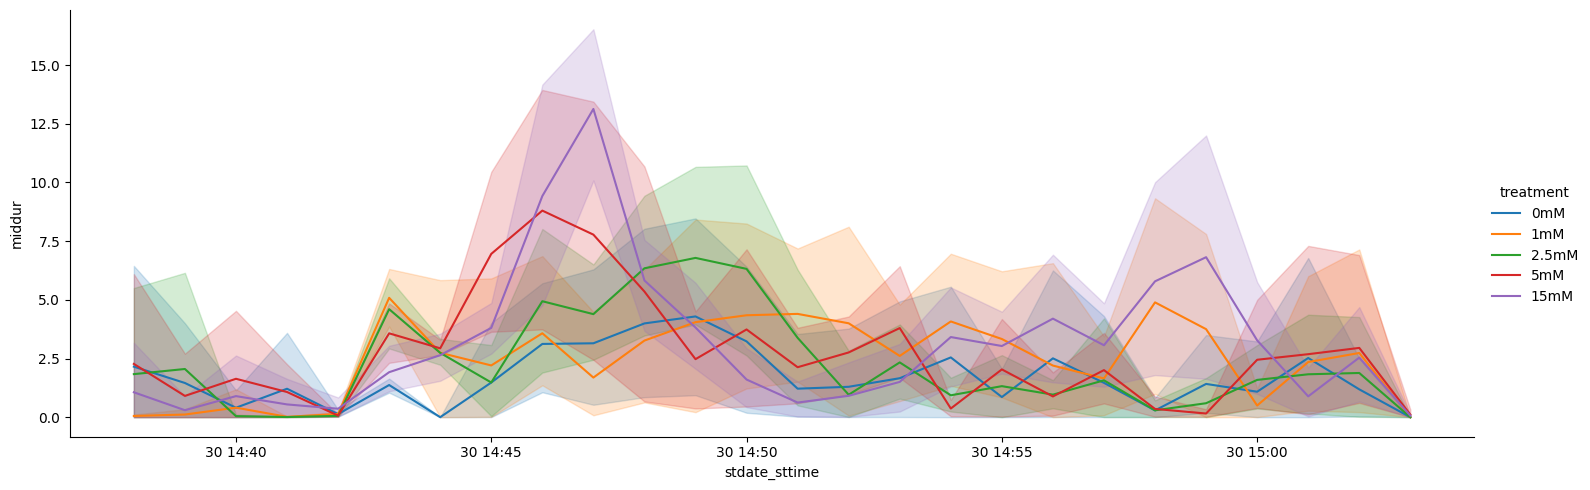

In [7]:
sns.relplot(x="stdate_sttime", y="middur",data=final_data, kind="line", hue='treatment', aspect=3)


In [5]:
len(final_data['animal'].unique())

30

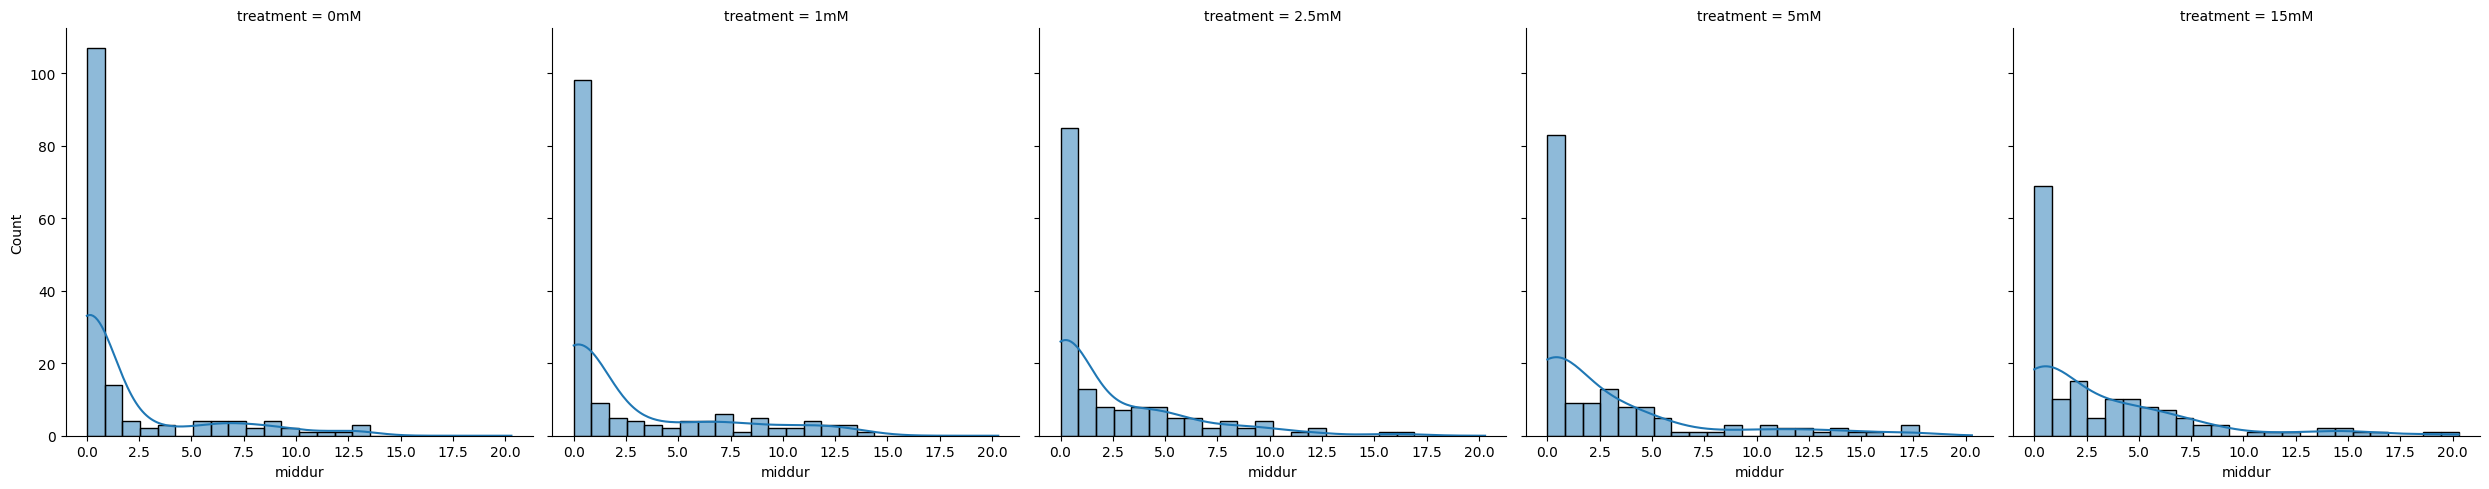

In [125]:
sns.displot(data=final_data, x="middur", col="condition", kde=True)

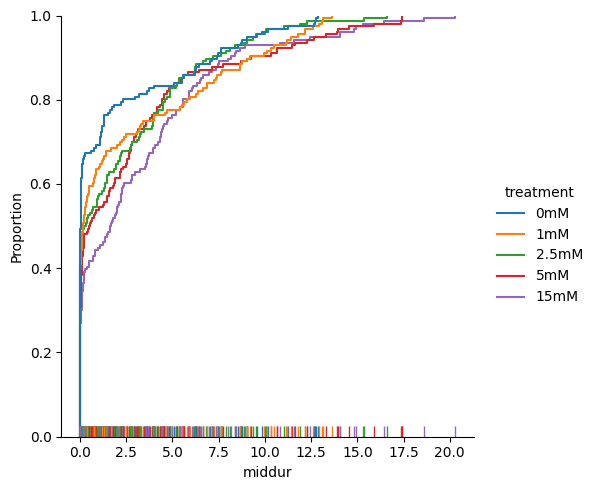

In [126]:
sns.displot(data=final_data, kind="ecdf", x="middur", hue="condition", rug=True)

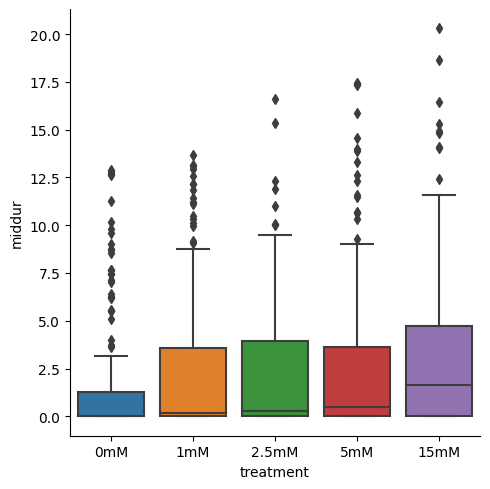

In [162]:
sns.catplot(data=final_data, kind='box', x="condition", y="middur")


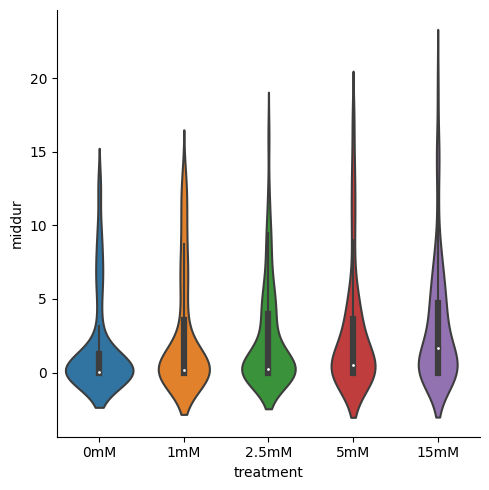

In [152]:
sns.catplot(data=final_data, kind="violin", x="condition", y="middur",errorbar=('ci', 95))